# GTR analysis

In [646]:
#import cairo
import json
import matplotlib.pyplot as plt
import os
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

from datetime import datetime
from itertools import combinations
import networkx as nx
import community #Get this package: http://perso.crans.org/aynaud/communities/

if 'outputs' not in os.listdir():
    os.mkdir("outputs")

In [3]:
def write_network(g):
    out_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    out_dir = out_dir + '/data/networks/'
    out_file = out_dir + 'gtr_network_' + datetime.now().strftime('%Y%m%d%H%M') + '.gml'
    try:
        os.makedirs(out_dir, exist_ok=True)
    except OSError:
        "Print output directory already exists. Saving network to {}".format(out_file)
    nx.write_gml(g, out_file)

def extract_network_from_corpus(label_corpus, edge_attr="None", stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
        #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus.iloc[i], 2))

        #Extract these as lists of dicts capturing connections between topics, and add those to the container.
        #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]

            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort(columns=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort(columns=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph) 

In [6]:
config_file = os.path.dirname(os.path.dirname(os.getcwd())) + '/config.json'

#Load config file
with open(config_file, 'r') as f:
    config = json.load(f)

#Create connection string
conn_string = 'host={} dbname={} user={} password={}'.format(
                    config.get("host"),
                    config.get("database"),
                    config.get("user"),
                    config.get("passw"))

#Create connection
conn = psycopg2.connect(conn_string)

In [7]:
#Read the data
#We'll read it in chunks
chunk= 500

#Create sql query string
sql_query_str="""
    SELECT
        *
    FROM
        gtr.projects      
"""

#Read the data
results = pd.read_sql(sql_query_str,con=conn,chunksize=chunk)

#Create df from results
projects_df = pd.DataFrame()
for result in results:
     projects_df = projects_df.append(result)
        
pd.options.mode.chained_assignment = None  # default='warn'

#reindex
projects_df.reset_index(drop=True,inplace=True)

#Select relevant columns and subset
rel_vars = ['pkey','abstract_texts','grant_cats','href','identifiers',
            'lead_org_dpts','links','research_subjects','research_topics','status']
projects_rel_df = projects_df[rel_vars]

#Extract the json elements form their 1 element-dicts
projects_rel_df['research_subjects'] = projects_rel_df[
    'research_subjects'].map(lambda x: x['researchSubject'])

projects_rel_df['research_topics'] = projects_rel_df[
    'research_topics'].map(lambda x: x['researchTopic'])

In [8]:
#Focus analysis on research grant and fellowship projects
#Subset
projects_academic_df = projects_rel_df[[i in ['Research Grant','Fellowship'] for
                                                 i in projects_rel_df.grant_cats]]
        
#Only consider projects with subject data (drop nas and )
projects_w_subject_df = projects_academic_df[projects_academic_df.research_topics.notnull()]
projects_w_subject_df = projects_academic_df[[len(i)>0 for i in
                                             projects_academic_df.research_topics]]

#Extract research subjects and research topics.
projects_w_subject_df['subject_list'] = [[i['text'] for i in sublist] for sublist in 
                                       projects_w_subject_df['research_subjects']]
projects_w_subject_df['topic_list'] = [[i['text'] for i in sublist] for sublist in 
                                       projects_w_subject_df['research_topics']]

In [30]:
projects_all_subjects = pd.Series([i for sublist in projects_w_subject_df['subject_list'] for
                       i in sublist])
projects_all_topics = pd.Series([i for sublist in projects_w_subject_df['topic_list'] for
                       i in sublist])

In [56]:
# Network Object Creation
net = extract_network_from_corpus(projects_w_subject_df.topic_list, stop_words="Research approaches")

net2 = extract_network_from_corpus(projects_w_subject_df.subject_list)

#It appears that updating the networkx package has created some issues with the community detection module.
#No matter. We're not really using this now.


#Extract communities (discipline aggregates)
#topic_communities = community.best_partition(net)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:60: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Higher Resolution Communities

The community detection above gives just 6 communities. We would like to, if possible, identify higher resolution communities. We can try to accompish this using igraph

In [201]:
def get_labelled_cluster_allocations(clust_memb,vertex_list=g.vs['label']):
    '''
    Takes a list with community memberships and a list of vertex labels and returns 
    a df with rows = comms and cols = labels in that comm
    '''
    
    df = pd.DataFrame({'comm':clust_memb,'labels':vertex_list}).groupby(
        'comm')['labels'].apply(lambda x: list(x))
    return(df)
       

In [46]:
# Import igraph
import igraph

In [57]:
# Save the networkx object to gml
write_network(net)
write_network(net2)

In [202]:
# The following methodology comes from
# http://stackoverflow.com/questions/25254151/using-igraph-in-python-for-community-detection-and-writing-community-number-for

# Read it from igraph. Specify the graph you want here.
g = igraph.read('../../data/networks/gtr_network_201608111227.gml')

In [224]:
# calculate dendrogram
edge_betweenness_dendrogram = g.community_edge_betweenness(weights='weight')

# convert it into a flat clustering
edge_betweenness_clusters = edge_betweenness_dendrogram.as_clustering()

# get the membership vector
edge_betweenness_membership = edge_betweenness_clusters.membership

In [225]:
#Results
eb_allocations = get_labelled_cluster_allocations(edge_betweenness_membership)
eb_allocations
print(edge_betweenness_clusters.modularity)

0.28309829523388264


In [214]:
#Run Walktrap (based on random walks in the network)
walktrap_dendogram = g.community_walktrap(weights='weight')
walktrap_clusters = walktrap_dendogram.as_clustering()
walktrap_membership = walktrap_clusters.membership

#Results
walktrap_clusters.summary()
wt_allocations = get_labelled_cluster_allocations(walktrap_membership)
wt_allocations
print(walktrap_clusters.modularity)

0.6127682608117928


In [265]:
#Run infomap algorithm (check definition)
infomap_clusters = g.community_infomap(edge_weights='weight')
infomap_membership = infomap_clusters.membership
info_allocations = get_labelled_cluster_allocations(infomap_membership)
info_allocations

print(infomap_clusters.modularity)

0.599729689814375


In [215]:
#Run eigenvector algorithm
eigen_clusters = g.community_leading_eigenvector(weights='weight')
eigen_clusters_membership = eigen_clusters.membership
eigen_memberships = get_labelled_cluster_allocations(eigen_clusters_membership,g.vs['label'])
eigen_memberships
eigen_clusters.modularity

0.5775853201836908

In [217]:
#Run label progagation algorithm
label_prop_clusters = g.community_label_propagation(weights='weight')
label_prop_clusters_membership = label_prop_clusters.membership
label_prop_memberships = get_labelled_cluster_allocations(label_prop_clusters_membership,g.vs['label'])
label_prop_memberships
label_prop_clusters.modularity

0.610377858547112

In [221]:
#Run spinglass algorithm based on physics. 
spinglass_clusters = g.community_spinglass(weights='weight')
spinglass_clusters_membership = spinglass_clusters.membership
spinglass_memberships = get_labelled_cluster_allocations(spinglass_clusters_membership,g.vs['label'])
spinglass_memberships
spinglass_clusters.modularity

0.6238166306145433

## Community allocation

In [287]:
#We will use Infomap: it generates more granular sets of communities with relatively high levels of activity.
#It is apparently more suitable for bibliometric analysis.
#Labelling:
import re
comm_labels = {
    0:'humanities',
    1:'environment', 
    2:'engineering_chemistry_materials_energy',
    3:'biosciences',
    4:'social_sciences_core',
    5:'computing',
    6:'social_sciences_policy_geography',
    7:'physics_astronomy',
    8:'mathematics',
    9:'psychology',
    10:'engineering_civil',
    11:'linguistics',
    12:'music',
    13:'social_sciences_economics',
    14:'law',
    15:'social_sciences_organisation',
    16:'social_sciences_education',
    17:'philosophy',
    18:'social_sciences_marketing',
    19:'physics_synchroton'    
}

#Create df with rows looking up topics and comm labels
top_comm_index_lookup = pd.concat([pd.DataFrame({'comm':n,'topic':x}) for n,x in 
                                   enumerate(list(info_allocations))])

#NB some characters have gone funny.
top_comm_index_lookup['topic'] = [re.sub("&#38;","&",x) for x in top_comm_index_lookup['topic']]

#Apply labels
comm_memb_lookup = {top:comm_labels[comm] for comm,top in zip(top_comm_index_lookup.comm,
                                                            top_comm_index_lookup.topic) }


In [316]:
projects_w_subject_df['segment_list'] = [
    [comm_memb_lookup[x] for x in element] for element in projects_w_subject_df.topic_list]

projects_w_subject_df['segment_summary'] =["; ".join(sorted(list(set(x)))) for x in projects_w_subject_df['segment_list']]

#Relabel instances with more than three combinations of disciplines.
#NB we still have 113 unique combinations.
projects_w_subject_df['segment_clean'] = [x if x.count(";")<=1 else 'mixed' 
                                          for x in projects_w_subject_df['segment_summary']]


### Merge with organisations and geo-coding (LAD level)

In [621]:
import geopandas
from geopandas import tools
from shapely.geometry import Point

def check_lat_lon(row):
    """Returns false if the row has null lat or lng values"""
    return True if not pd.isnull(row.lat) or not pd.isnull(row.lng) else False

In [622]:
#Access and geocode organisations
#Download org data
#Code copied and pasted from 
#https://github.com/nestauk/gtr_analysis/blob/master/notebooks/data_munging/map_organisations.ipynb


sql_str = """
    SELECT organisations.name, 
        organisations.id,
        organisations.addresses,
        orgs_latlng.lat,
        orgs_latlng.lng
    FROM gtr.organisations
    LEFT JOIN gtr.orgs_latlng
    ON gtr.organisations.id = gtr.orgs_latlng.id
"""

# Read in config file with DB params
with open('../../config.json') as f:
    conf = json.load(f)
    
# Define a connection string
conn_string = 'host={} dbname={} user={} password={}'.format(conf.get('host'),
                                                             conf.get('database'),
                                                             conf.get('user'),
                                                             conf.get('passw'))

# Create a connection object
conn = psycopg2.connect(conn_string)

# Dataframe from SQL data
org_df = pd.read_sql(sql_str, conn)


In [628]:
# Create a column that shapely recognises as geographic coordinates
org_df2 = org_df.copy()

org_df2["geometry"] = org_df2.apply(lambda row: Point(row["lng"], row["lat"]) if check_lat_lon(row) else None, axis=1)
org_df2.drop(['lat', 'lng'], axis=1, inplace=True)

# Now we need a GeoDataFrame and to tell
# Geopandas what the coordinate system used is
org_df2 = geopandas.GeoDataFrame(org_df2, geometry="geometry")
org_df2.crs = {"init": "epsg:4326"}

# Now load the topojson to a seperate GeoDataFrame object
lads = geopandas.GeoDataFrame.from_file("../industry/data_input/topo_lad.json")
lads.crs = {"init": "epsg:4326"}

# Perform the spatial join
org_df2 = tools.sjoin(lads, org_df2[org_df2.geometry.notnull()], how="left")
org_df2.rename(columns={'id_left': 'lad', 'id_right': 'id'}, inplace=True)

# LUT Output
org_df2[['name', 'id', 'lad']].to_pickle("../industry/intermediate_outputs/lad.p")
org_df2.to_csv("../industry/intermediate_outputs/orgs_df.csv", index=False)

In [629]:
#Merge
#Need to create a version of the DF linking orgs to projects

#Convoluted dict comprehension that extracts an org id from the links field if this is indeed an organisation
projects_orgs_lookup_1 = [[x['href'] for x in els['link'] if 'ORG' in x['rel']] for
                                      els in projects_w_subject_df.links] 

#Some of the lists above have more than one organisation in them
projects_orgs_lookup_flat = pd.concat([pd.DataFrame({'href':href,'orgs':orgs}) for href,orgs in
                                     zip(projects_w_subject_df.href,projects_orgs_lookup_1)])

#Create clean version of org href with text
projects_orgs_lookup_flat['org_id_text'] = projects_orgs_lookup_flat['orgs'].map(lambda x: x.split("/")[-1])

In [630]:
#Merges
#TODO check all this with James. Do we lose orgs because they are international? Because they weren't geocoded? both? 

org_vars = ['LAD13CD','LAD13NM','lad','name','id']
proj_vars = [x for x in projects_w_subject_df.columns if x not in ['grant_cats','status']]

project_org_merged = pd.merge(
    pd.merge(org_df2[org_vars],
             projects_orgs_lookup_flat,left_on='id',right_on='org_id_text'),
    projects_w_subject_df,
    left_on='href',right_on='href',sort=False)


In [631]:
lad_subjects = pd.crosstab(project_org_merged.LAD13NM,project_org_merged.segment_clean).reset_index()

In [632]:
#Calculate LQs. What do we normalise by: Business populations?
city_biz_counts = pd.read_csv("../industry/intermediate_outputs/city_biz_counts.csv")
city_biz_counts.rename(columns={"local authority: district / unitary (prior to April 2015)":'lad',
                               '0':'biz_counts'},inplace=True)

In [633]:
#Produce LQ
#Merge
lad_subject_for_lq = pd.merge(lad_subjects,
                         city_biz_counts,
                         left_on='LAD13NM',right_on='lad')
#Lose the lad variable
lad_subject_for_lq.drop('lad',inplace=True,axis=1)

#Generate LQs
#Local shares 1 (based on biz counts in the city)
local_shares_1 = lad_subject_for_lq.biz_counts/lad_subject_for_lq.biz_counts.sum()

#Local shares 2 (based on colsums in the matrix, removing the last column with business counts)
local_shares_2 = lad_subject_for_lq.ix[:,1:-1].sum(axis=1)/np.sum(lad_subject_for_lq.ix[:,1:-1].sum(axis=1))


lad_subject_lq = lad_subject_for_lq.ix[:,1:].apply(lambda x: (x/x.sum()/local_shares))
lad_subject_lq.index = lad_subject_for_lq['LAD13NM']


In [647]:
#Let's focus on the top 20 segments/combinations
top_subjects = projects_w_subject_df['segment_clean'].value_counts()[:20].index

lad_subject_lq_selected = lad_subject_lq.ix[:,top_subjects]

lad_subject_lq_selected.to_csv("outputs/gtr_subjects.csv")


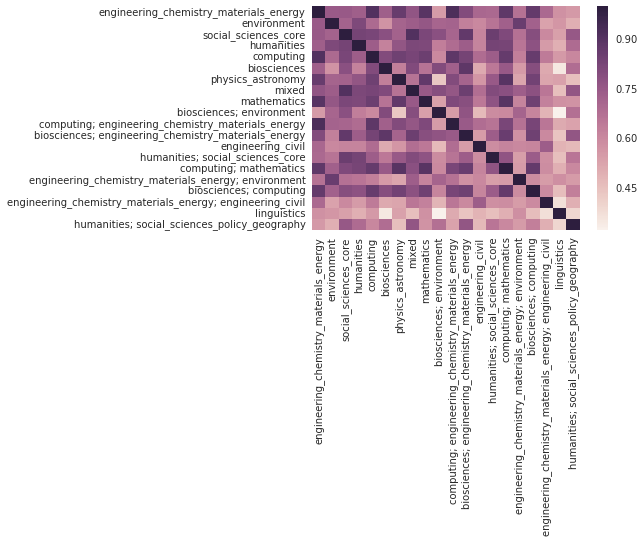

In [635]:
sns.heatmap(lad_subject_lq_selected.corr())

In [636]:
industry_clusters = pd.read_csv("../industry/intermediate_outputs/industry_clusters.csv")

In [637]:
#Merge industry and research clusters

all_activity = pd.merge(industry_clusters,lad_subject_lq_selected.reset_index(drop=False),
                       left_on='lad_name',
                       right_on='LAD13NM')

all_activity_corr_1 = all_activity.corr()

all_activity_corr = all_activity_corr_1.ix[industry_clusters.columns[1:],lad_subject_lq_selected.columns[1:]]


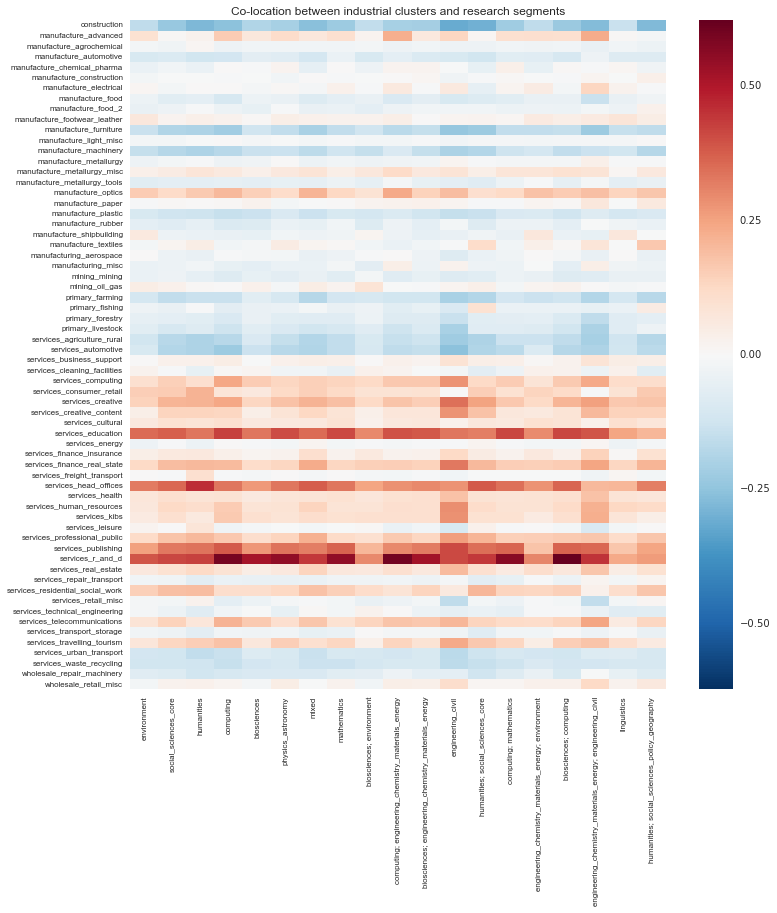

In [638]:
#Plot relations
plot = plt.figure(figsize=(12,12))
plot = sns.heatmap(all_activity_corr)
plot.tick_params(labelsize=8)
plt.title("Co-location between industrial clusters and research segments")